In [166]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [167]:
n_iters = 100000
print_every = 5000
plot_every = 1000

In [168]:
# Vocabulary
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

def findFiles(path): return glob.glob(path)

In [169]:
data_dir = os.path.join(os.pardir, 'data', 'worldcities.csv')
raw_df = pd.read_csv(data_dir)[['city_ascii', 'country']]

# Listing all cities for each country
grouped_cities = raw_df.groupby('country')['city_ascii'].apply(list).reset_index(name='cities')

# Removing all countries where number of cities < 100
city_count = raw_df.groupby('country').count().reset_index()
countries_to_keep = city_count[city_count.city_ascii > 100].country
grouped_cities = grouped_cities[grouped_cities.country.isin(countries_to_keep)]


# Preparing country city dict and label list
all_countries = grouped_cities['country'].unique().tolist()
city_dict = {country: city_lst for country, city_lst in grouped_cities.to_numpy()}
n_categories = len(all_countries)
print(n_categories)

50


In [170]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [171]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.hidden_comp = nn.Linear(input_size + hidden_size, hidden_size)
        self.output_comp = nn.Linear(input_size + hidden_size, hidden_size)
        self.output2output = nn.Linear(hidden_size, output_size)
        self.tanh_act = nn.Tanh()
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        
        combined = torch.cat((x, hidden), 1)
        hidden = self.hidden_comp(combined)
        hidden = self.tanh_act(hidden)
        
        output = self.output_comp(combined)
        output = self.tanh_act(output)
        output = self.output2output(output)
        output = self.lsoftmax(output)
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [172]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_countries[category_i], category_i

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_countries)
    line = randomChoice(city_dict[category])
    category_tensor = torch.tensor([all_countries.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train(category_tensor, line_tensor, optim, criterion, model):
    
    model.train()
    hidden = model.initHidden()
    model.zero_grad()
    
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)

    # Iterate through the whole line!
    for i in range(line_tensor.size()[0]):
        hidden = hidden.to(device)
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    
    # zero the parameter gradients
    optim.zero_grad()
    loss.backward()
    optim.step()

    return output, loss.item()

In [173]:
criterion = nn.NLLLoss() # Because we are using Log_softmax
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
N_HIDDEN = 128

model_basic = RNN(n_letters, N_HIDDEN, n_categories) #Vocab_size, hidden size, output classes
model_basic = model_basic.to(device)
optimizer = optim.SGD(model_basic.parameters(), lr=learning_rate)

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor, optimizer, criterion, model_basic)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 15s) 3.7901 Aldershot / Czechia ✗ (United Kingdom)
10000 10% (0m 31s) 3.7887 Ribnica / Brazil ✗ (Slovenia)
15000 15% (0m 47s) 3.8484 Deblin / Philippines ✗ (Poland)
20000 20% (1m 3s) 4.1266 Las Terrenas / Brazil ✗ (Dominican Republic)
25000 25% (1m 18s) 4.2543 Burshtyn / Germany ✗ (Ukraine)
30000 30% (1m 34s) 2.5244 Pacasmayo / Peru ✓
35000 35% (1m 51s) 3.1815 Concepcion del Uruguay / Guatemala ✗ (Argentina)
40000 40% (2m 7s) 2.2671 Kapellen / Netherlands ✗ (Belgium)
45000 45% (2m 23s) 3.0712 Cappeln / Mexico ✗ (Germany)
50000 50% (2m 39s) 2.1071 Frutigen / Germany ✗ (Switzerland)
55000 55% (2m 55s) 2.7627 Rorvik / Ukraine ✗ (Norway)
60000 60% (3m 11s) 3.1920 San Andres Villa Seca / Serbia ✗ (Guatemala)
65000 65% (3m 27s) 4.0676 Le Rheu / Thailand ✗ (France)
70000 70% (3m 42s) 2.4893 Sao Joao del Rei / Thailand ✗ (Brazil)
75000 75% (3m 59s) 3.3019 Abdul Hakim / Syria ✗ (Pakistan)
80000 80% (4m 14s) 2.2882 Glogow / South Africa ✗ (Poland)
85000 85% (4m 30s) 2.4576 Schwechat 

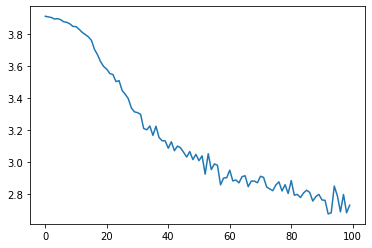

In [174]:
# PLOT THE RESULT

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [187]:
def evaluate(line_tensor, model):
    model.eval()
    hidden = model.initHidden()
    line_tensor = line_tensor.to(device)

    for i in range(line_tensor.size()[0]):
        hidden = hidden.to(device)
        output, hidden = model(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line), model_basic)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_countries[category_index]))
            predictions.append([value, all_countries[category_index]])

predict('Oslo')
predict('Stockholm')
predict('London')
predict('Iraq')


> Oslo
(-1.71) Finland
(-2.44) Italy
(-2.83) Norway

> Stockholm
(-1.52) South Africa
(-1.80) United Kingdom
(-2.24) Germany

> London
(-1.56) South Africa
(-2.25) United Kingdom
(-2.45) Czechia

> Iraq
(-1.89) Syria
(-2.11) Egypt
(-2.29) Iran


## Pytorch RNN

In [176]:
def categoryToTensor(category):
    tensor = torch.zeros([1, len(all_countries)], dtype=torch.long)
    tensor[0][all_countries.index(category)] = 1
    return tensor

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_countries)
    line = randomChoice(city_dict[category])
    category_tensor = categoryToTensor(category)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [177]:
class RNNPytorch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNPytorch, self).__init__()

        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True) # 1 is num_layers
        self.fc = nn.Linear(hidden_size, output_size)
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):

        hidden, output = self.rnn(x, hidden)

        output = output.contiguous().view(-1, self.hidden_size)
        output = self.fc(output)
        output = self.lsoftmax(output)
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

def train_pytorch_model(category_tensor, line_tensor, optim, criterion, model):
    
    model.train()
    hidden = model.initHidden()
    model.zero_grad()
    line_tensor = line_tensor.permute(1, 0, 2)    
    
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)
    
    # Iterate through the whole line!
    hidden = hidden.to(device)
    output, hidden = model(line_tensor, hidden)

    loss = criterion(output, torch.topk(category_tensor, 1).indices.view(-1))
    
    # zero the parameter gradients
    optim.zero_grad()
    loss.backward()
    optim.step()

    return output, loss.item()

### Training 

In [178]:
criterion = nn.NLLLoss() # Because we are using Log_softmax
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
N_HIDDEN = 128

model_pytorch = RNNPytorch(n_letters, N_HIDDEN, n_categories) #Vocab_size, hidden size, output classes
model_pytorch = model_pytorch.to(device)
optimizer = optim.SGD(model_pytorch.parameters(), lr=learning_rate)

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_pytorch_model(category_tensor, line_tensor, optimizer, criterion, model_pytorch)
    current_loss += loss
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 3.9375 Trebon / Dominican Republic ✗ (Czechia)
10000 10% (0m 15s) 3.4943 Nyons / Austria ✗ (France)
15000 15% (0m 22s) 4.2337 Tigzirt / Poland ✗ (Algeria)
20000 20% (0m 29s) 2.6013 Hai'an / Syria ✗ (China)
25000 25% (0m 37s) 2.1251 Kaplice / Czechia ✓
30000 30% (0m 44s) 3.4802 Kosvik / Ukraine ✗ (Norway)
35000 35% (0m 52s) 2.8229 Khenchela / India ✗ (Algeria)
40000 40% (1m 0s) 3.6842 Tactic / Serbia ✗ (Guatemala)
45000 45% (1m 7s) 4.9090 Tumbes / Belgium ✗ (Peru)
50000 50% (1m 14s) 1.7678 Wezembeek-Oppem / Belgium ✓
55000 55% (1m 21s) 2.7402 Monte Plata / Colombia ✗ (Dominican Republic)
60000 60% (1m 28s) 2.2256 Jamaat Shaim / Syria ✗ (Morocco)
65000 65% (1m 35s) 2.4722 Finnsnes / France ✗ (Norway)
70000 70% (1m 42s) 3.2685 Cardenden / Austria ✗ (United Kingdom)
75000 75% (1m 49s) 3.3089 Melipilla / Guatemala ✗ (Chile)
80000 80% (1m 56s) 1.4094 Nyirbator / Hungary ✓
85000 85% (2m 3s) 3.5837 Anini-y / Japan ✗ (Philippines)
90000 90% (2m 10s) 1.0851 Disuq / Egypt ✓
95000 

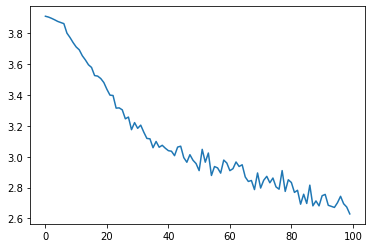

In [179]:
# PLOT THE RESULT

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [ ]:
def evaluate(line_tensor, model):
    model.eval()
    hidden = model.initHidden()
    hidden = hidden.to(device)

    line_tensor = line_tensor.permute(1, 0, 2)
    line_tensor = line_tensor.to(device)
    output, hidden = model(line_tensor, hidden)
    
    return output


def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line), model_pytorch)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_countries[category_index]))
            predictions.append([value, all_countries[category_index]])

predict('New York')
predict('Stockholm')
predict('London')
predict('Iraq')


> New York
(-1.56) Russia
(-1.98) Poland
(-2.33) Hungary

> Stockholm
(-1.59) Hungary
(-2.49) Iran
(-2.55) Ukraine

> London
(-1.34) United Kingdom
(-2.01) South Africa
(-2.14) Australia

> Iraq
(-1.73) Kazakhstan
(-1.80) Egypt
(-2.38) Syria


## GRU Net

In [181]:
class RNNPytorch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNPytorch, self).__init__()

        self.hidden_size = hidden_size
        
        self.rnn = nn.GRU(input_size, hidden_size, num_layers=1, batch_first=True) # 1 is num_layers
        self.fc = nn.Linear(hidden_size, output_size)
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):

        hidden, output = self.rnn(x, hidden)

        output = output.contiguous().view(-1, self.hidden_size)
        output = self.fc(output)
        output = self.lsoftmax(output)
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

def train_pytorch_model(category_tensor, line_tensor, optim, criterion, model):
    
    model.train()
    hidden = model.initHidden()
    model.zero_grad()
    line_tensor = line_tensor.permute(1, 0, 2)    
    
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)
    
    # Iterate through the whole line!
    hidden = hidden.to(device)
    output, hidden = model(line_tensor, hidden)

    loss = criterion(output, torch.topk(category_tensor, 1).indices.view(-1))
    
    # zero the parameter gradients
    optim.zero_grad()
    loss.backward()
    optim.step()

    return output, loss.item()

### Training 

In [190]:
criterion = nn.NLLLoss() # Because we are using Log_softmax
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
N_HIDDEN = 128

model_gru = RNNPytorch(n_letters, N_HIDDEN, n_categories) #Vocab_size, hidden size, output classes
model_gru = model_gru.to(device)
optimizer = optim.SGD(model_gru.parameters(), lr=learning_rate)

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_pytorch_model(category_tensor, line_tensor, optimizer, criterion, model_gru)
    current_loss += loss
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 3.7267 Triuggio / Italy ✓
10000 10% (0m 14s) 3.8601 As / Belgium ✗ (Norway)
15000 15% (0m 21s) 3.9834 Dabas / Portugal ✗ (Hungary)
20000 20% (0m 28s) 4.0409 Setif / Switzerland ✗ (Algeria)
25000 25% (0m 35s) 3.7849 Kuchinarai / India ✗ (Thailand)
30000 30% (0m 42s) 3.1673 Offenbach an der Queich / Belgium ✗ (Germany)
35000 35% (0m 49s) 3.4662 Nord-Fron / Germany ✗ (Norway)
40000 40% (0m 56s) 3.3429 Vossevangen / Germany ✗ (Norway)
45000 45% (1m 3s) 3.4572 Waterford / Netherlands ✗ (Australia)
50000 50% (1m 11s) 3.7925 Moncada / Peru ✗ (Philippines)
55000 55% (1m 18s) 3.9642 Hostos / Argentina ✗ (Dominican Republic)
60000 60% (1m 26s) 4.0475 Comox / Slovakia ✗ (Canada)
65000 65% (1m 32s) 3.4738 Drouin / China ✗ (Australia)
70000 70% (1m 39s) 1.8581 Villa Tapia / Dominican Republic ✓
75000 75% (1m 46s) 4.1292 Mol / Philippines ✗ (Belgium)
80000 80% (1m 53s) 4.2665 Saumalkol / Philippines ✗ (Kazakhstan)
85000 85% (2m 0s) 2.3168 Gowerton / United Kingdom ✓
90000 90% (2m 7s)

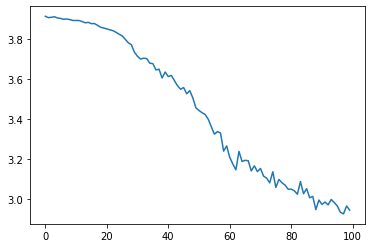

In [191]:
# PLOT THE RESULT

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [193]:
def evaluate(line_tensor, model):
    model.eval()
    hidden = model.initHidden()
    hidden = hidden.to(device)

    line_tensor = line_tensor.permute(1, 0, 2)
    line_tensor = line_tensor.to(device)
    output, hidden = model(line_tensor, hidden)
    
    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line), model_gru)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_countries[category_index]))
            predictions.append([value, all_countries[category_index]])

predict('New York')
predict('Stockholm')
predict('London')
predict('Iraq')


> New York
(-2.22) Russia
(-2.26) Kazakhstan
(-2.52) Norway

> Stockholm
(-1.99) Russia
(-2.34) Norway
(-2.56) United Kingdom

> London
(-2.37) South Africa
(-2.41) United Kingdom
(-2.73) Netherlands

> Iraq
(-2.35) Egypt
(-2.39) Syria
(-2.62) Iran
